In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# **Loading Data**

In [2]:
images = []
ages = []

for i in os.listdir('../input/utkface-new/crop_part1/'):
    split = i.split('_')
    ages.append(int(split[0]))
    images.append(Image.open('../input/utkface-new/crop_part1/' + i))

In [3]:
images = pd.Series(list(images), name = 'Images')
ages = pd.Series(list(ages), name = 'Ages')

df = pd.concat([images, ages], axis=1)
df

,Images,Ages
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,26
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,21
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,17
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,76
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,18
...,...,...
9775,<PIL.JpegImagePlugin.JpegImageFile image mode=...,26
9776,<PIL.JpegImagePlugin.JpegImageFile image mode=...,66
9777,<PIL.JpegImagePlugin.JpegImageFile image mode=...,41
9778,<PIL.JpegImagePlugin.JpegImageFile image mode=...,2


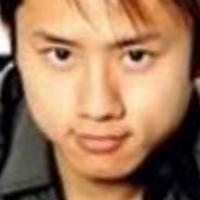

26


In [4]:
display(df['Images'][0])
print(df['Ages'][0])

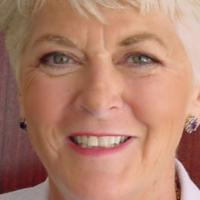

72


In [5]:
display(df['Images'][10])
print(df['Ages'][10])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Ages', ylabel='Count'>

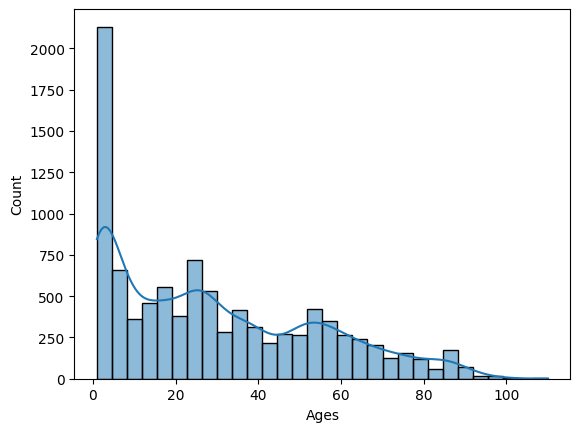

In [6]:
sns.histplot(df['Ages'],kde=True, bins=30)

In [7]:
# Too many faces of people between 0 and 4 years old. The model would fit too well to these ages and not enough to the other ages. 
# To resolve this I'm only going to include a third of the images between these ages.

under4s = []

for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac=0.3)

df = df[df['Ages'] > 4]

df = pd.concat([df, under4s], ignore_index = True)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Ages', ylabel='Count'>

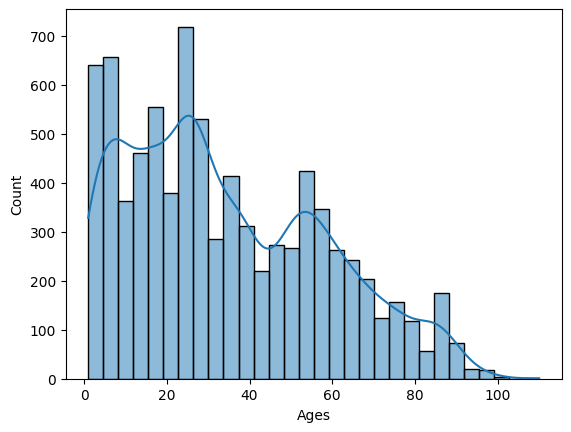

In [8]:
sns.histplot(df['Ages'],kde=True, bins=30)

In [9]:
# There aren't many images of people over 80, which would cause the model to not train well enough on those ages. 
# It's best to just remove over 80s and only have a model that can predict the ages of people under 80.

df = df[df['Ages'] < 80]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Ages', ylabel='Count'>

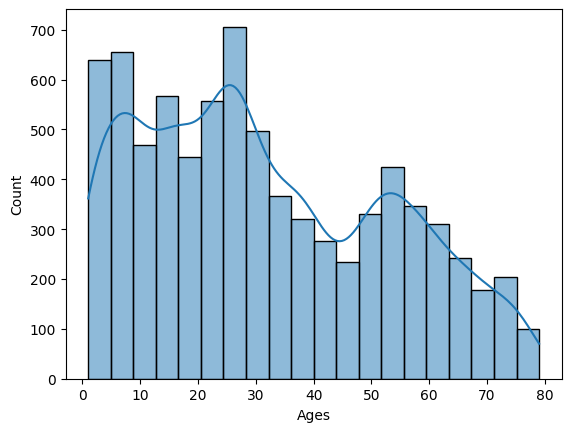

In [10]:
sns.histplot(df['Ages'],kde=True, bins=20)

In [12]:
x = []
y = []

for i in range(len(df)):
    df.loc[i, 'Images'] = df['Images'].iloc[i].resize((200,200))
    ar = np.asarray(df['Images'].iloc[i])
    x.append(ar)
    age = [int(df['Ages'].iloc[i])]
    y.append(age)
x = np.array(x)

# **Train Test Split**

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# **Creating the model**

In [22]:
agemodel = Sequential()
agemodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(64, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(128, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Flatten())
agemodel.add(Dense(64, activation='relu'))
agemodel.add(Dropout(0.5))
agemodel.add(Dense(1, activation='relu'))

agemodel.compile(loss='mean_squared_error',
             optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['mae'])

# **Training the model**

In [23]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train1 = datagen.flow(x_train, y_train, batch_size=32)

test1 = test_datagen.flow(
        x_test, y_test,
        batch_size=32)

history1 = agemodel.fit(train1, epochs=50, shuffle=True, validation_data=test1)

Epoch 1/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 56s 258ms/step - loss: 698.8685 - mae: 21.3084 - val_loss: 448.6949 - val_mae: 17.9450
Epoch 2/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 49s 238ms/step - loss: 466.5211 - mae: 17.8022 - val_loss: 336.0787 - val_mae: 15.2069
Epoch 3/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 48s 236ms/step - loss: 416.5367 - mae: 16.5256 - val_loss: 351.3618 - val_mae: 14.4316
Epoch 4/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 49s 239ms/step - loss: 363.5569 - mae: 15.2551 - val_loss: 277.9257 - val_mae: 13.2299
Epoch 5/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 49s 239ms/step - loss: 349.2371 - mae: 14.7378 - val_loss: 294.6689 - val_mae: 14.0163
Epoch 6/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 49s 239ms/step - loss: 336.1069 - mae: 14.4208 - val_loss: 262.5240 - val_mae: 13.1307
Epoch 7/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 49s 239ms/step - loss: 331.2990 - mae: 14.3070 - val_loss: 251.4272 - val_mae: 12.7656
Epoch 8/50
197/197 ━━━━━━━━━━━━━━━━━━━━ 49s 238ms/step - loss: 320.2604 - mae: 13.9925 - val_loss: 261.5027 - v

In [25]:
losses = pd.DataFrame(agemodel.history.history)

<Axes: >

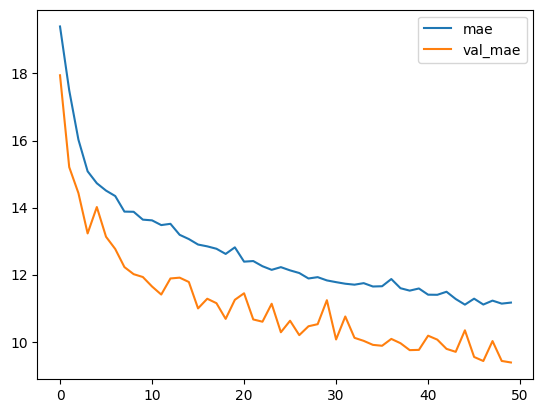

In [27]:
losses[['mae','val_mae']].plot()

<Axes: >

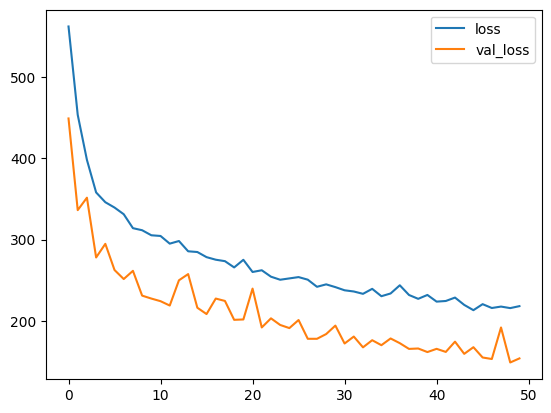

In [28]:
losses[['loss','val_loss']].plot()

In [30]:
agemodel.save('age_model.keras')

# **Evaluating the model**

In [2]:
from keras.models import load_model

In [3]:
loaded_model = load_model('/kaggle/input/age_model/tensorflow2/default/1/age_model.keras')

In [4]:
def process_and_predict(file, agemodel):
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((200,200))
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200))
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200))
            
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)
    
    age = agemodel.predict(ar)
        
    print('Age:', int(age[0][0]))
    return im.resize((300,300))

I0000 00:00:1726889851.699275     101 service.cc:145] XLA service 0x7eecd40060a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726889851.699352     101 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Age: 8


I0000 00:00:1726889853.105144     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


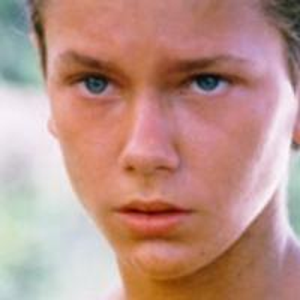

In [5]:
process_and_predict('/kaggle/input/utkface-new/crop_part1/16_0_0_20170110231645188.jpg.chip.jpg',loaded_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Age: 12


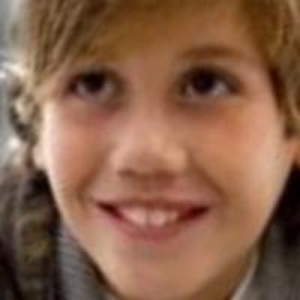

In [9]:
process_and_predict('/kaggle/input/utkface-new/crop_part1/10_0_0_20170110220316298.jpg.chip.jpg',loaded_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Age: 11


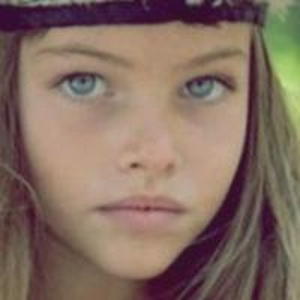

In [10]:
process_and_predict('/kaggle/input/utkface-new/crop_part1/13_1_0_20170109203635557.jpg.chip.jpg',loaded_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Age: 3


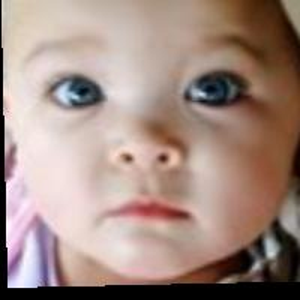

In [12]:
process_and_predict('/kaggle/input/utkface-new/crop_part1/1_0_0_20161219154018476.jpg.chip.jpg',loaded_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Age: 24


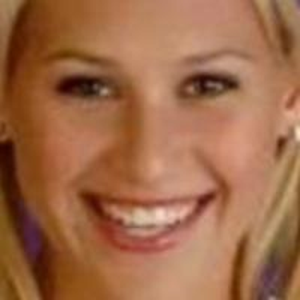

In [13]:
process_and_predict('/kaggle/input/utkface-new/crop_part1/20_1_0_20170104020855852.jpg.chip.jpg',loaded_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Age: 26


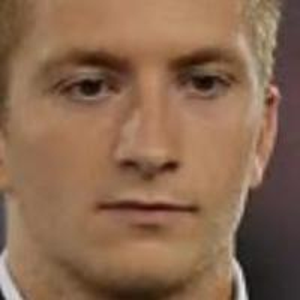

In [18]:
process_and_predict('/kaggle/input/utkface-new/crop_part1/25_0_0_20170104214616710.jpg.chip.jpg',loaded_model)